# Imbalanced classes — anomaly detection

One different approach to dealing with class imbalance is to convert the problem to one of anomaly detection. This is appropiate when dealing with a two class problem where the minority class is particularly rare. Here you produce a model that predicts whether a data point is different to those in the majority class.

One approach is training a one-class support vector machine (SVM). This SVM is trained only on the majority class and aims to create a decision boundary which encapsulates all the training data. Any new data point that is predicted to lie outside of this decision boundary is consider to not belong to the majority, and hence (in our case) must lie within the minority class.

Let's re-introduce the imbalanced before and then train it on a normal SVM (that can see both of the classes) for comparision.

In [1]:
from __future__ import division

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from imblearn.datasets import make_imbalance

from sklearn.svm import SVC
from sklearn.svm import OneClassSVM
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, classification_report

# Define a function for plotting data.
def plot_data(X, y):
    plt.scatter(X[y == 0, 0], X[y == 0, 1], alpha=0.5)
    plt.scatter(X[y == 1, 0], X[y == 1, 1], alpha=0.5)
    plt.show()

## Example problem

Below (following the example shown in the introduction) an imblanced classification problem is produced using the cresent moon dataset generator from *sklean* and the routines from *imblearn* that take a dataset and make it imbalanced.

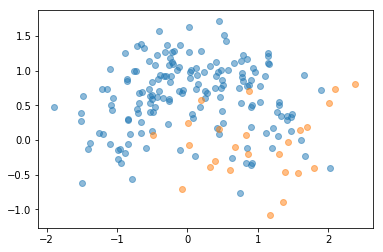

In [2]:
# Based on the imbalance_learn package examples
X, y = make_moons(n_samples=500, shuffle=True, noise=0.4, random_state=40)
X_, y_ = make_imbalance(X, y, ratio=0.15, min_c_=1, random_state=40)

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X_, y_, test_size=0.33, random_state=40, stratify=y_)
plot_data(X_train, y_train)

The data can be split into training and test sets and then a linear support vector machine fitted. F1-score can then be used to look at the efficacy of the model.

In [3]:
# Define and fit model
model = SVC(random_state=40, probability=True)
model.fit(X_train, y_train)

# Make predictions
y_predict = model.predict(X_test)

# Output the precision, recall and f1-score
print classification_report(y_true=y_test, y_pred=y_predict)

             precision    recall  f1-score   support

          0       0.91      1.00      0.95        83
          1       1.00      0.33      0.50        12

avg / total       0.92      0.92      0.90        95



## One-class support vector machine

First we need to limit our trainig data to just be the majority class and then fit the model.

In [4]:
X_anom = X_train[y_train==0]

model_anom = OneClassSVM(nu=0.05, random_state=40, gamma=0.5)
model_anom.fit(X_anom)


y_predict = model_anom.predict(X_test)

y_predict = [0 if predict==1 else 1 for predict in y_predict]

# Output the precision, recall and f1-score
print classification_report(y_true=y_test, y_pred=y_predict)

             precision    recall  f1-score   support

          0       0.91      0.84      0.88        83
          1       0.28      0.42      0.33        12

avg / total       0.83      0.79      0.81        95



The results are very sensitive to the _nu_ parameter.

The results are not particularly impressive but when we haven't used any data from the minority class. This approach is more appropiate minority class is a very small percentage of the data.

Let's plot out the decision function on the training data to see what is going on.

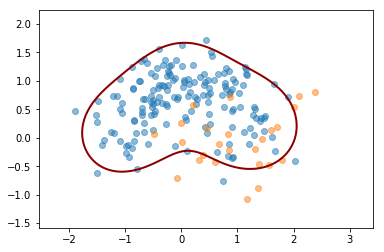

In [5]:
# Find the max and min values of the two features and pad abit
X0_min, X0_max = X_[:, 0].min()-0.5, X_[:, 0].max()+0.5
X1_min, X1_max = X_[:, 1].min()-0.5, X_[:, 1].max()+0.5

# Create a grid of points
step = 200
X0, X1 = np.meshgrid(np.linspace(X0_min, X0_max, step), np.linspace(X1_min, X1_max, step))
grid = np.c_[X0.ravel(), X1.ravel()]

# Calculate the decision boundary at the grid points
db = model_anom.decision_function(grid)
db = db.reshape(X0.shape)

# Plot the decision boundary and the data points
plt.scatter(X_train[y_train == 0, 0], X_train[y_train == 0, 1], alpha=0.5)
plt.scatter(X_train[y_train == 1, 0], X_train[y_train == 1, 1], alpha=0.5)
plt.contour(X0, X1, db, levels=[0], linewidths=2, colors='darkred')

plt.show()

The red line is the decision boundary and this was trained on only the blue points. The one-class model has learnt the correct cresent moon shape of the majority class; however, ,any of the minority class points are also captured within the decision boundary. This is not that surprisingly as the the moons of the two classes do overlap (particularly with the degree of noise) and the model has no information about the minority class.

Similarily this can be plotted on the test data.

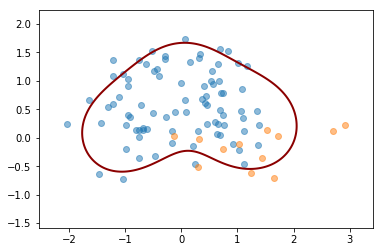

In [6]:
# Plot the decision boundary and the data points
plt.scatter(X_test[y_test == 0, 0], X_test[y_test == 0, 1], alpha=0.5)
plt.scatter(X_test[y_test == 1, 0], X_test[y_test == 1, 1], alpha=0.5)
plt.contour(X0, X1, db, levels=[0], linewidths=2, colors='darkred')

plt.show()

Showing a similiar picture.